In [2]:
import graphs
import modelz
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
import embedder

In [71]:
#Creates and saves graph
g = graphs.klemm_eguiluz(3,20000)
graphs.w2f(g,"KE20000_bis.edgelist")

In [72]:
#Instantiates embedder objet (file requiered)
n_features = 128
n_walks = 40
walk_len = 50
window_size = 10
n_iterations = 20
embedder = embedder.embedder('KE20000_bis.edgelist', False, False, 2, 0.1)

In [73]:
#Generates and stores graph embeddings
embedder.embed(n_features, n_walks, walk_len, window_size, n_iterations)
embeddings = embedder.get_embeddings()
embedder.w2f('KE20000_bis_embeddings.dat')

In [88]:
#If graph and embeddings are already saved
g = nx.read_edgelist("KE10000.edgelist", nodetype = int)
embeddings_list = []
with open(file = 'KE10000_embeddings.dat') as f:
    for line in f:
        splited_line = line.split('\t')
        aux = []
        for i in range(0,len(splited_line)-1):
            aux.append(float(splited_line[i]))
        embeddings_list.append(np.array(aux))
embeddings = np.array(embeddings_list)

 50%|█████     | 1004/2000 [00:13<00:13, 76.14it/s] 


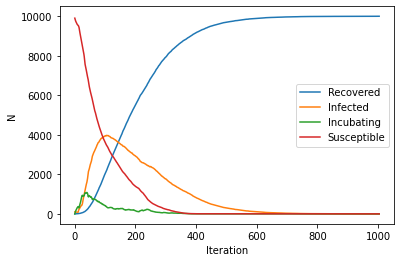

In [89]:
#Parameters:
beta = 0.1
gamma = 0.01
m = 0.0
delay = 10
I0 = 100
max_it = 2000

#Instantietes model and runs simulation:
test_model = modelz.SIR_bis(g.copy(), g.number_of_nodes(), beta, gamma, m, delay, I0)
iterations = test_model.full_simulation(max_it)
#Plot desease evolution over time, to get an insight on the dynamics before training the model.
plt.plot([it['node_count'][3] for it in iterations], label = 'Recovered')
plt.plot([it['node_count'][2] for it in iterations], label = 'Infected')
plt.plot([it['node_count'][1] for it in iterations], label = 'Incubating')
plt.plot([it['node_count'][0] for it in iterations], label = 'Susceptible')
plt.legend(loc = 'best')
plt.xlabel('Iteration')
plt.ylabel('N')
plt.show()
#print('Mean degree: ', 2*g.number_of_edges()/float(g.number_of_nodes()))
#print('Average shortest path length: ', nx.average_shortest_path_length(g))

In [90]:
#Get per node frecuency of states, i.e., (#Sus/#It, #Inc/#It, #Inf/#It, #Rec/#It)
per_it_states = []
for j in range(len(iterations)): 
    it_status = iterations[j]['status'] #Select a specific iteration to test
    per_it_states.append(list(it_status.values()))
per_node_states = np.array(per_it_states).T.tolist()
per_node_frec = []
posible_states = [0,1,2,3]
for node_states in per_node_states:
    per_node_frec.append(np.array([node_states.count(x)/len(node_states) for x in set(posible_states)]))

In [6]:
def frec_to_states(state_frec): #Turns vector of frecuencies to an array of states: (0.2,0.1,0.4,0.2) -> (0,0,1,2,2,2,2,3,3)
    it_s = round(state_frec[0]*len(iterations))
    it_inc = round(state_frec[1]*len(iterations)) 
    it_inf = round(state_frec[2]*len(iterations)) 
    it_r = len(iterations) - it_inc - it_inf - it_s
    aux = []
    for j in range(0,len(iterations)):
        if j < it_s:
            aux.append(0)
        if it_s <= j < it_s + it_inc:
            aux.append(1)
        if it_s + it_inc <= j < len(iterations) - it_r:
            aux.append(2)
        if len(iterations) - it_r <= j:
            aux.append(3) 
    return aux
    
def get_per_it_states(states_frec): #Converts a list of vectos of frecuencies (i.e. the output of the model) to #States predicted per it. 
    per_node_pred_states = []
    for i in range(0,len(states_frec)):
        aux = frec_to_states(states_frec[i])
        per_node_pred_states.append(aux)
    per_it_pred_states = np.array(per_node_pred_states).T.tolist()
    return per_it_pred_states

In [91]:
train_embeddings, test_embeddings, train_labels, test_labels = model_selection.train_test_split(embeddings, per_node_frec, test_size=0.75)

In [82]:
import tensorflow as tf
w1 = 1
w2 = 1
w3 = 1.25
w4 = 1.25

# Custom loss function - mean of binary crossentropy and mean squared error
def customLoss(y_true, y_prediction):
    yt = tf.cast(y_true, dtype = 'float32')
    yp = tf.cast(y_prediction, dtype = 'float32')
    aux0 = tf.math.abs(yp[:,0]-yt[:,0])*w1
    aux1 = tf.math.abs(yp[:,1]-yt[:,1])*w2
    aux2 = tf.math.abs(yp[:,2]-yt[:,2])*w3
    aux3 = tf.math.abs(yp[:,3]-yt[:,3])*w4
    return tf.reduce_mean(aux0+aux1+aux2+aux3)

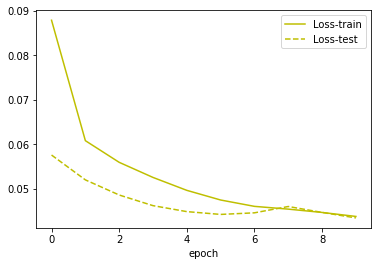

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input
from keras import backend as K

model = Sequential()
model.add(Dense(128, activation='relu', input_dim = len(embeddings[0])))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
#model.add(Dense(len(per_node_frec[0]), activation='relu'))
#model.add(Lambda(lambda x: tf.divide(x, K.sum(x, axis = 1, keepdims=True))))
model.add(Dense(len(per_node_frec[0]), activation='softmax'))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ["acc"])
history = model.fit(train_embeddings, np.array(train_labels),validation_data=(test_embeddings, np.array(test_labels)),epochs = 10, verbose = 0)
pred = model.predict(test_embeddings, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1)
plt.plot(history.history['loss'], 'y',label= 'Loss-train')
plt.plot(history.history['val_loss'],'y--', label= 'Loss-test')
plt.legend(loc = 'best')
plt.xlabel('epoch')
plt.show()

In [93]:
per_it_true_states = get_per_it_states(test_labels)
per_it_pred_states = get_per_it_states(pred)
per_it_pred_s = [p.count(0) for p in per_it_pred_states]
per_it_pred_inc = [p.count(1) for p in per_it_pred_states]
per_it_pred_inf = [p.count(2) for p in per_it_pred_states]
per_it_pred_r = [p.count(3) for p in per_it_pred_states]
per_it_true_s = [p.count(0) for p in per_it_true_states]
per_it_true_inc = [p.count(1) for p in per_it_true_states]
per_it_true_inf = [p.count(2) for p in per_it_true_states]
per_it_true_r = [p.count(3) for p in per_it_true_states]

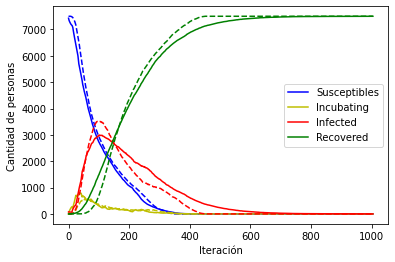

In [94]:
plt.plot(per_it_true_s,'b', label = 'Susceptibles')
plt.plot(per_it_pred_s,'b--')
plt.plot(per_it_true_inc,'y', label = 'Incubating')
plt.plot(per_it_pred_inc,'y--')
plt.plot(per_it_true_inf,'r', label = 'Infected')
plt.plot(per_it_pred_inf,'r--')
plt.plot(per_it_true_r,'g', label = 'Recovered')
plt.plot(per_it_pred_r,'g--')
plt.legend(loc = 'best')
plt.xlabel('Iteración')
plt.ylabel('Cantidad de personas')
plt.show()

In [83]:
from numpy import linalg as LA
def get_per_node_error(predicted, true):
        diff = abs(predicted - true)
        return diff        
mean_errors = np.array([0,0,0,0], dtype = 'float64')
per_node_mean_error = []
for i in range(0,len(pred)):
    diff = get_per_node_error(pred[i], test_labels[i])
    mean_errors += diff
    per_node_mean_error.append(LA.norm(diff))
mean_errors = mean_errors/len(pred)
print(mean_errors)

[0.03033926 0.00440521 0.05216623 0.06275532]


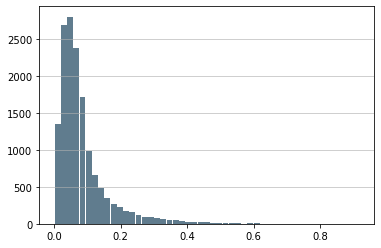

In [70]:
min_error = min(per_node_mean_error)
max_error = max(per_node_mean_error)
bins = np.linspace(min_error,max_error, 50)
plt.hist(per_node_mean_error, bins = bins, rwidth=0.95, color='#607c8e')
plt.grid(axis='y', alpha=0.75)
plt.show()

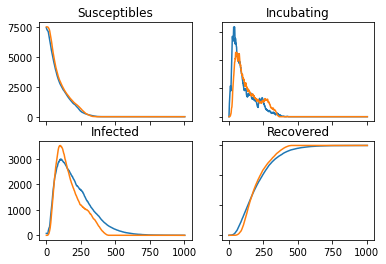

In [95]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(per_it_true_s, label = 'True')
axs[0, 0].plot(per_it_pred_s, label = 'Pred')
axs[0, 0].set_title('Susceptibles')
axs[0, 1].plot(per_it_true_inc, label = 'True')
axs[0, 1].plot(per_it_pred_inc, label = 'Pred')
axs[0, 1].set_title('Incubating')
axs[1, 0].plot(per_it_true_inf, label = 'True')
axs[1, 0].plot(per_it_pred_inf, label = 'Pred')
axs[1, 0].set_title('Infected')
axs[1, 1].plot(per_it_true_r, label = 'True')
axs[1, 1].plot(per_it_pred_r, label = 'Pred')
axs[1, 1].set_title('Recovered')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    #ax.set_yscale('log')
    ax.label_outer()